# Load and Modify MedCyclone Dataset
Upload your MedCyclone dataset and define the temporal and spatial extent of your analysis. 
Filter the cyclone tracks crossing at least one grid point corresponding to the Mediterranean Sea and Black Sea (henceforth **Mediterranean basin**).

### Original Dataset
- df_tracks_in = input MedCyclone dataset. One of the datasets created and described in [Flaounas et al. (2023)](https://wcd.copernicus.org/articles/4/639/2023/). As an example, we take TRACKS_CL5 consisting of 3808 cyclone tracks spending at least 24h in the Mediterranean region, tracked with confidence level 5 (see details in paper).

### Generated Dataset:
- *df_tracks_infoMedcrossers* = df_tracks_in with desired time and ID filtering + one additional column with info about if each cyclone is a "Medcrosser". This informs whether or not a cyclone (ID) crosses the Mediterranean basin (TRUE/FALSE). Can be used as a filter for heat lows over North Africa.

- *df_tracks_onlyMedcrossers* = df_tracks_in with desired time, ID and Medcrosser filtering. It consists of only the cyclones that cross the Mediterranean basin (column "Medcrosser" == TRUE).

In [14]:
# Load python packages
import numpy as np
from scipy.io import savemat
import xarray as xr

import QS_functions as QSfunc

In [15]:
# Directories
data_dir = "../data/"
output_dir = "../output/"
# Input track file
input_file = "other_TRACKS/TRACKS_CL8.dat"   # or other_TRACKS/TRACKS_CL#.dat

In [16]:
# Selection storm IDs, year range, months and time frequency
id_storm = 0 # all storms
year_range = [1979,2020] # [start_year, end_year]... available from 1979 to 2020
months = [] # if [] then all months, otherwise e.g. ['1','2'] for January and February
t_int = 1         # time interval (in t_int_u). The stationarity definitions are tuned to 1 hour time intervals.
t_int_u = 'h'

# Construct time array
t_start =  str(year_range[0])+'-01-01T00'
t_end = str(year_range[1]+1)+'-01-01'
t_last = np.array(t_end, dtype='datetime64') - np.timedelta64(t_int, t_int_u)
t_last = str(t_last)[:10] 
var_time = QSfunc.timerange_datetime(t_start,t_end,t_int,t_int_u, months)

In [18]:
# Open track dataset
df_tracks_in = QSfunc.open_tracks_flaounas(path_name=data_dir+input_file)
# Define df_tracks_in column names
df_tracks_in.columns = ['id','lon','lat','year','month','day','time','hPa']

# Storm selection, by ID and time range/frequency
df_tracks_sel = QSfunc.get_storms_sometime(df_tracks_in, id_storm, var_time)

# Make variable time array
time_tracks_sel = QSfunc.make_var_time(df_tracks_sel) # same as var_time but with time steps in the dataset

In [19]:
print(df_tracks_sel.head())

   id     lon     lat  year  month  day  time      hPa
0   1 -19.060  31.310  1979      1    5     4  1005.25
1   1 -18.126  31.260  1979      1    5     5  1004.66
2   1 -17.286  31.219  1979      1    5     6  1004.09
3   1 -16.690  31.069  1979      1    5     7  1003.66
4   1 -16.318  30.817  1979      1    5     8  1003.79


# How to Filter Heat Lows from df_tracks_sel?

Select IDs of MedCyclone tracks crossing the Mediterranean basin in at least one time instance. 
1. Sea mask: define crossing area (Mediterranean basin)
2. Find nearest neighbour for each coordinate of a cyclone path and define new coordinates in grid of sea mask
3. Check for each cyclone in df_tracks_sel if they cross Mediterranean basin (Medcrosser=TRUE) or not (Medcrosser=FALSE). Useful to filter heat-lows!
4. Save datasets with Medcrosser info

### 1. Sea Mask
Upload land-sea mask and define area of interest (Mediterranean basin)

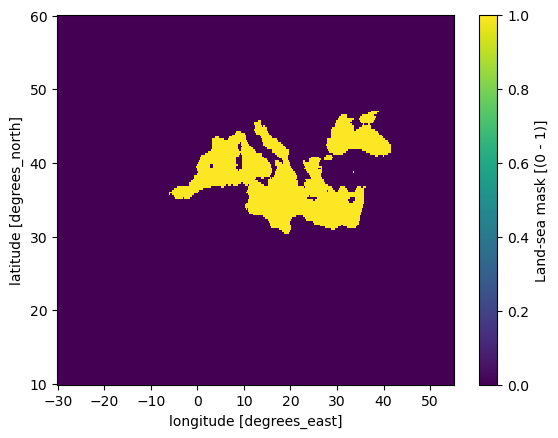

In [20]:
# Load land-sea mask
ds_s = xr.open_dataset(data_dir+'land_sea_mask.nc', engine="netcdf4")

# Round values in dataset to nearest integer (so there are only 0/1)
ds_s['lsm'].values = np.round(ds_s['lsm'].values, 0)

# Exchange 0 and 1 (so that sea=1, land=0)
ds_s['lsm'].values = np.where(ds_s['lsm'].values == 1, 0, 1)

# # Plot land-sea mask
# ds_s['lsm'].plot()

# Define area of interest
sea_mask_in = ds_s['lsm']
sea_mask_e = sea_mask_in.where((sea_mask_in.lat<=48)&(sea_mask_in.lat>=30)&(sea_mask_in.lon<=42)&(sea_mask_in.lon>=-6),0)
sea_mask = sea_mask_e.where(((sea_mask_e.lat<=43)|(sea_mask_e.lon>=0)),0)

# Plot final sea points
sea_mask.plot()

### 2. Nearest Neighbour
Assign to each coordinate of a cyclone's track it's nearest neighbouring gridpoint (from the sea mask)

In [21]:
# Definitions
# Grid sea_mask (dimensions)
lon = np.array(sea_mask.lon)
lat = np.array(sea_mask.lat)
grid = np.array(list(zip(lon,lat)))

In [22]:
# FIND_NEAREST_INDEX: All points df_tracks_sel
# Loop id-wise
list_coord = []                                                         # create list of ids and coords

for id_track in df_tracks_sel['id'].unique():                              # for each unique id in df_tracks_sel
    track = df_tracks_sel[df_tracks_sel['id'] == id_track]                    # select track with id_track
    coords = []
    for _, row in track.iterrows():                                     # for each row[1] (lon), row[2] (lat) point in the track
        ix, iy = QSfunc.find_nearest_index(lon, lat, row[1], row[2])        # find nearest index in lon, lat
        coords.append((lon[ix], lat[iy]))
    list_coord.append([id_track] + coords)

list_coord[0]

[1,
 (-19.0, 31.25),
 (-18.25, 31.25),
 (-17.25, 31.25),
 (-16.75, 31.0),
 (-16.25, 30.75),
 (-16.0, 30.5),
 (-16.0, 30.25),
 (-15.75, 29.75),
 (-15.75, 29.5),
 (-15.5, 29.25),
 (-15.5, 29.25),
 (-15.25, 29.25),
 (-15.0, 29.25),
 (-14.75, 29.25),
 (-14.5, 29.5),
 (-14.25, 29.5),
 (-14.0, 29.5),
 (-14.0, 29.5),
 (-14.0, 29.75),
 (-13.75, 29.75),
 (-13.75, 30.0),
 (-13.75, 30.25),
 (-13.75, 30.25),
 (-13.75, 30.5),
 (-13.75, 30.5),
 (-14.0, 30.5),
 (-14.0, 30.5),
 (-14.25, 30.5),
 (-14.5, 30.25),
 (-14.5, 30.25),
 (-14.5, 30.0),
 (-14.5, 29.75),
 (-14.5, 29.5),
 (-14.5, 29.5),
 (-14.5, 29.5),
 (-14.25, 29.25),
 (-14.25, 29.25),
 (-14.0, 29.25),
 (-14.0, 29.5),
 (-13.75, 29.5),
 (-13.75, 29.5),
 (-13.75, 29.5),
 (-13.5, 29.75),
 (-13.5, 29.75),
 (-13.25, 30.0),
 (-13.25, 30.0),
 (-13.25, 30.25),
 (-13.25, 30.25),
 (-13.25, 30.5),
 (-13.25, 30.75),
 (-13.25, 30.75),
 (-13.25, 31.0),
 (-13.25, 31.25),
 (-13.25, 31.25),
 (-13.25, 31.5),
 (-13.25, 31.75),
 (-13.25, 31.75),
 (-13.25, 32.0),
 (

### 3. Define Medcrossers
- Create a mask for each ID with 1 for track point in Mediterranean basin, 0 for track point outside
- Compare each mask with sea_mask and create list of cyclones that cross the Mediterranean basin in at least one time instance (Medcrossers)

In [23]:
# Check if each track has points in common with sea_mask
ids_medtracks = []

lon_idx_map = {v: i for i, v in enumerate(lon)}
lat_idx_map = {v: j for j, v in enumerate(lat)}

for inner_list in list_coord:

    # Create mask for each track, indicating grid points that are part of the track
    id = inner_list[0]
    coord_i = inner_list[1:]

    mask_i = np.zeros((len(lat), len(lon)), dtype=int)
    for x, y in coord_i:
        i = lon_idx_map.get(x)
        j = lat_idx_map.get(y)
        if i is not None and j is not None:
            mask_i[j, i] = 1

    # Check if the track mask has at least one point in common with sea_mask
    mask_cross = mask_i * sea_mask  # Multiply with sea_mask
    if np.sum(mask_cross) >= 1:
        ids_medtracks.append(id)

print(f"Medcrosser cyclone IDs: {ids_medtracks}")


Medcrosser cyclone IDs: [2, 3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 70, 72, 76, 77, 78, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 125, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 199, 200, 202, 203, 204, 205, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 226, 227, 231, 232, 234, 235, 236, 239, 240, 241, 242, 243, 244, 246, 247, 248, 252, 253, 255, 257, 258, 259, 260, 262, 

### 4. Save Medcrossers
- Update df_tracks_sel with Medcrosser information (column "Medcrossers", *df_tracks_infoMedcrossers*) and save
- Filter Medcrossers in df_tracks_sel (*df_tracks_onlyMedcrossers*) and save

In [25]:
# Create new dataframe with df_tracks_sel+medcrosser info (df_tracks_infoMedcrossers)
df_tracks_infoMedcrossers = df_tracks_sel.copy()  # Create a copy of df_tracks_sel
df_tracks_infoMedcrossers['Medcrosser'] = df_tracks_infoMedcrossers['id'].isin(ids_medtracks)
# Save dataset
df_tracks_infoMedcrossers.to_csv(output_dir + input_file[:-4] + '_infoMedcrossers.csv', index=False, header=True)

# Create new dataframe selecting only Medcrossers from df_tracks_sel (df_tracks_Medcrossers)
df_tracks_onlyMedcrossers = df_tracks_sel[df_tracks_infoMedcrossers['Medcrosser'] == True]
# Save dataset
df_tracks_onlyMedcrossers.to_csv(output_dir + input_file[:-4] + '_onlyMedcrossers.csv', index=False, header=True)

In [24]:
df_tracks_infoMedcrossers.head()

,id,lon,lat,year,month,day,time,hPa,Medcrosser
0,1,-17.750,48.120,1979,1,3,1,995.45,False
1,1,-17.447,48.163,1979,1,3,2,993.78,False
2,1,-16.979,48.143,1979,1,3,3,992.60,False
3,1,-16.344,48.078,1979,1,3,4,991.93,False
4,1,-15.679,48.031,1979,1,3,5,990.32,False


In [26]:
df_tracks_onlyMedcrossers.head()

,id,lon,lat,year,month,day,time,hPa
229,4,0.960,40.700,1979,1,8,18,1016.93
230,4,1.080,40.761,1979,1,8,19,1016.93
231,4,1.300,40.746,1979,1,8,20,1016.64
232,4,1.624,40.699,1979,1,8,21,1016.35
233,4,1.986,40.693,1979,1,8,22,1015.86
